In [ ]:
import yfinance as yf
import os

# 상위 10개 S&P 500 종목 예시
TICKERS = ['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'META', 'NVDA', 'TSLA', 'BRK-B', 'UNH', 'JNJ']

data_dir = '/content/drive/MyDrive/시계열/data/raw'
os.makedirs(data_dir, exist_ok=True)

def download_and_save(ticker, start='2010-01-01', end='2025-01-01'):
    df = yf.download(ticker, start=start, end=end)
    if not df.empty:
        df.reset_index().to_csv(f"{data_dir}/{ticker}.csv", index=False)
        print(f"Saved: {ticker}.csv")
    else:
        print(f"No data for {ticker}")

if __name__ == '__main__':
    for ticker in TICKERS:
        download_and_save(ticker)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved: AAPL.csv
Saved: MSFT.csv
Saved: AMZN.csv
Saved: GOOGL.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved: META.csv
Saved: NVDA.csv


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Saved: TSLA.csv
Saved: BRK-B.csv
Saved: UNH.csv
Saved: JNJ.csv


In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

def preprocess_stock_data(file_path):
    # CSV 읽기
    df = pd.read_csv(file_path)

    # 헤더 중복 문제 해결: 첫 행 제거 (만약 첫 행이 열 이름일 경우)
    if df.iloc[0].str.contains("AAPL|GOOG|MSFT|Close").any():  # 열 이름 포함 여부 검사
        df = df.iloc[1:].copy()

    # 날짜 처리
    if 'Date' not in df.columns:
        raise ValueError(f"'Date' column not found in {file_path}")

    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.set_index('Date', inplace=True)

    # 수치형 컬럼 변환
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 결측치 처리 (선형 보간 + 앞/뒤 채움 보완)
    df.interpolate(method='linear', inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # 이상치 제거: Z-score 기반
    for col in ['Close', 'Volume']:
        z_scores = (df[col] - df[col].mean()) / df[col].std()
        df = df[(z_scores < 3) & (z_scores > -3)]

    # 정규화
    scaler = MinMaxScaler()
    df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

    return df

def batch_preprocess_all(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            ticker = filename.replace('.csv', '')
            file_path = os.path.join(input_dir, filename)

            try:
                print(f"Processing {ticker}...")
                df = preprocess_stock_data(file_path)
                output_path = os.path.join(output_dir, f"{ticker}_processed.csv")
                df.to_csv(output_path)
                print(f"Saved: {ticker}_processed.csv")
            except Exception as e:
                print(f"Error processing {ticker}: {e}")

if __name__ == '__main__':
    data_dir = '/content/drive/MyDrive/시계열/data/raw'
    output_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
    batch_preprocess_all(data_dir, output_dir)


Processing AAPL...
Saved: AAPL_processed.csv
Processing MSFT...
Saved: MSFT_processed.csv
Processing META...
Saved: META_processed.csv
Processing TSLA...
Saved: TSLA_processed.csv
Processing AMZN...
Saved: AMZN_processed.csv
Processing NVDA...
Saved: NVDA_processed.csv
Processing BRK-B...
Saved: BRK-B_processed.csv
Processing GOOGL...
Saved: GOOGL_processed.csv
Processing JNJ...
Saved: JNJ_processed.csv
Processing UNH...
Saved: UNH_processed.csv


In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import warnings

# 경고 메시지 무시
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

def load_and_clean_stock_data(file_path: str) -> pd.DataFrame:
    """
    CSV 파일을 불러와 기본적인 클리닝을 수행합니다.
    (날짜 변환, 수치형 변환, 결측치 보간)

    Args:
        file_path (str): CSV 파일의 경로.

    Returns:
        pd.DataFrame: 기본 클리닝이 완료된 데이터프레임.
    """
    df = pd.read_csv(file_path)

    # 헤더 중복 문제 해결: 첫 행의 데이터 타입을 확인하여 더 강건하게 처리
    try:
        pd.to_numeric(df.iloc[0])
    except (ValueError, TypeError):
        # 첫 행이 숫자로 변환되지 않으면 헤더로 간주하고 제거
        df = pd.read_csv(file_path, header=1)

    # 'Date' 컬럼 처리
    if 'Date' not in df.columns:
        raise ValueError(f"'Date' column not found in {file_path}")
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df.dropna(subset=['Date'], inplace=True) # 날짜 변환 실패한 행 제거
    df.set_index('Date', inplace=True)

    # 분석에 사용할 수치형 컬럼 정의
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    # 파일에 없는 컬럼은 제외
    cols_to_process = [col for col in numeric_cols if col in df.columns]

    # 수치형 변환
    for col in cols_to_process:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    # 결측치 처리 (시계열 데이터에 적합한 보간법)
    # limit_direction='both'는 앞/뒤 방향 모두 채우도록 함
    df.interpolate(method='time', limit_direction='both', inplace=True)
    df.ffill(inplace=True)
    df.bfill(inplace=True)

    # 모든 컬럼이 결측치인 행 제거
    df.dropna(how='all', inplace=True)

    return df

def preprocess_for_prediction(data: pd.DataFrame, train_ratio: float = 0.8):
    """
    데이터 누수를 방지하며 훈련/테스트 데이터셋을 전처리합니다.
    - 이상치 처리와 정규화는 훈련 데이터 기준으로 수행됩니다.

    Args:
        data (pd.DataFrame): 클리닝이 완료된 전체 데이터프레임.
        train_ratio (float): 훈련 데이터셋의 비율.

    Returns:
        tuple: (
            pd.DataFrame: 처리된 훈련 데이터,
            pd.DataFrame: 처리된 테스트 데이터,
            MinMaxScaler: 훈련 데이터로 학습된 스케일러 객체
        )
    """
    # 훈련/테스트 데이터 분할 (시간 순서 기준)
    split_point = int(len(data) * train_ratio)
    train_df = data.iloc[:split_point].copy()
    test_df = data.iloc[split_point:].copy()

    print(f"훈련 데이터: {train_df.index.min()} ~ {train_df.index.max()} ({len(train_df)} 개)")
    print(f"테스트 데이터: {test_df.index.min()} ~ {test_df.index.max()} ({len(test_df)} 개)")

    # 처리할 컬럼 선택
    cols_to_process = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    cols_to_process = [col for col in cols_to_process if col in train_df.columns]

    # --- 이상치 처리 (Winsorization) ---
    # Z-score로 제거하는 대신, 극단값을 특정 분위수로 대체(Winsorize)하여 정보 손실을 최소화합니다.
    # 훈련 데이터 기준으로 경계값(threshold)을 계산합니다.
    for col in cols_to_process:
        lower_bound = train_df[col].quantile(0.01)
        upper_bound = train_df[col].quantile(0.99)

        # 훈련 데이터에 적용
        train_df[col] = np.clip(train_df[col], lower_bound, upper_bound)
        # 테스트 데이터에도 동일한 경계값 적용
        test_df[col] = np.clip(test_df[col], lower_bound, upper_bound)

    # --- 정규화 (Normalization) ---
    # 훈련 데이터 기준으로 MinMaxScaler를 학습(fit)시킵니다.
    scaler = MinMaxScaler()
    train_df[cols_to_process] = scaler.fit_transform(train_df[cols_to_process])

    # 학습된 스케일러를 사용하여 테스트 데이터를 변환(transform)합니다.
    test_df[cols_to_process] = scaler.transform(test_df[cols_to_process])

    return train_df, test_df, scaler

def batch_process_and_save(input_dir, output_dir):
    """
    모든 원본 데이터를 불러와 전처리하고, 훈련/테스트 데이터로 나누어 저장합니다.
    """
    os.makedirs(os.path.join(output_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'test'), exist_ok=True)

    for filename in os.listdir(input_dir):
        if filename.endswith('.csv'):
            ticker = filename.replace('.csv', '')
            file_path = os.path.join(input_dir, filename)

            try:
                print(f"--- Processing {ticker} ---")

                # 1. 파일 로드 및 기본 클리닝
                cleaned_df = load_and_clean_stock_data(file_path)

                if cleaned_df.empty:
                    print(f"Skipping {ticker} due to no valid data.")
                    continue

                # 2. 훈련/테스트 분할 및 전처리 (데이터 누수 방지)
                train_processed, test_processed, _ = preprocess_for_prediction(cleaned_df)

                # 3. 결과 저장
                train_output_path = os.path.join(output_dir, 'train', f"{ticker}_train.csv")
                test_output_path = os.path.join(output_dir, 'test', f"{ticker}_test.csv")

                train_processed.to_csv(train_output_path)
                test_processed.to_csv(test_output_path)

                print(f"Saved: {os.path.basename(train_output_path)} & {os.path.basename(test_output_path)}\n")

            except Exception as e:
                print(f"Error processing {ticker}: {e}\n")

if __name__ == '__main__':
    # Google Drive 사용 시 경로
    # from google.colab import drive
    # drive.mount('/content/drive')

    data_dir = '/content/drive/MyDrive/시계열/data/raw'
    output_dir = '/content/drive/MyDrive/시계열/data/processed'

    batch_process_and_save(data_dir, output_dir)


--- Processing AAPL ---
Error processing AAPL: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/AAPL.csv

--- Processing MSFT ---
Error processing MSFT: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/MSFT.csv

--- Processing META ---
Error processing META: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/META.csv

--- Processing TSLA ---
Error processing TSLA: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/TSLA.csv

--- Processing AMZN ---
Error processing AMZN: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/AMZN.csv

--- Processing NVDA ---
Error processing NVDA: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/NVDA.csv

--- Processing BRK-B ---
Error processing BRK-B: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/BRK-B.csv

--- Processing GOOGL ---
Error processing GOOGL: 'Date' column not found in /content/drive/MyDrive/시계열/data/raw/GOOGL.csv

--- Processing JNJ ---
Error proce

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dis

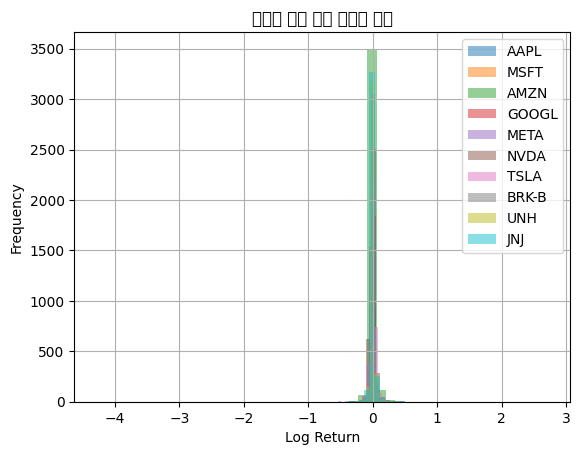

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

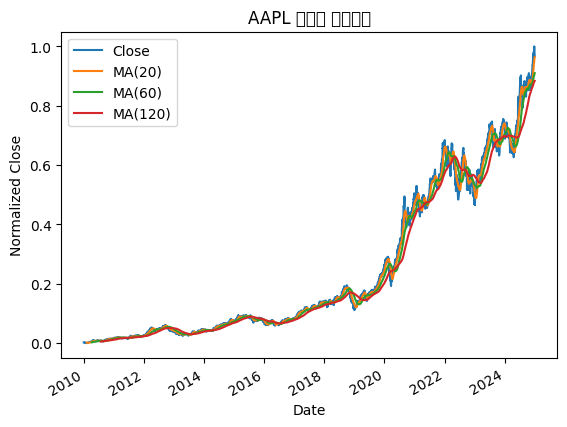

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

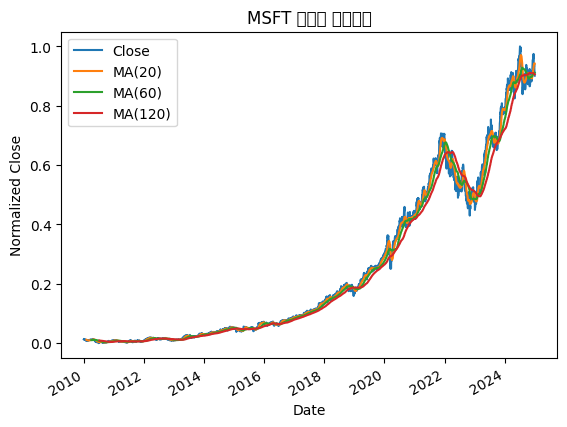

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

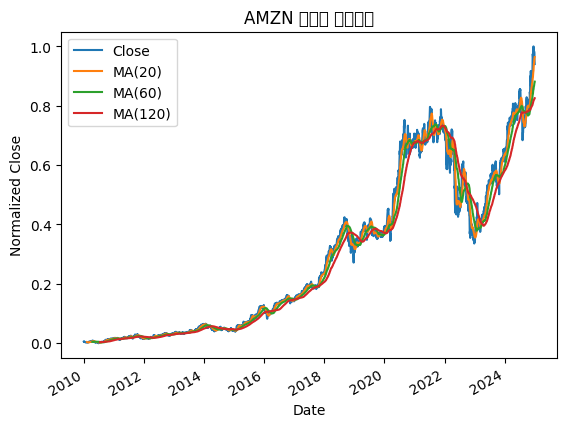

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

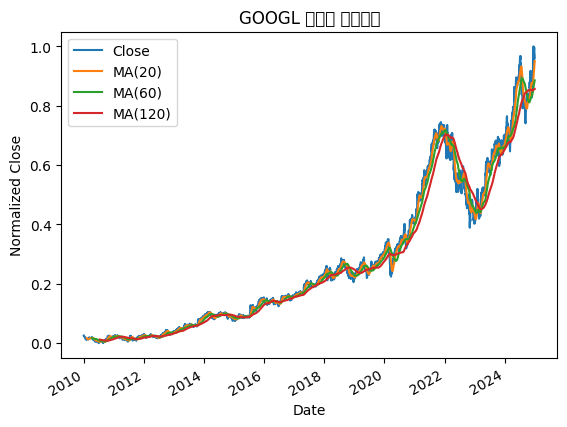

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

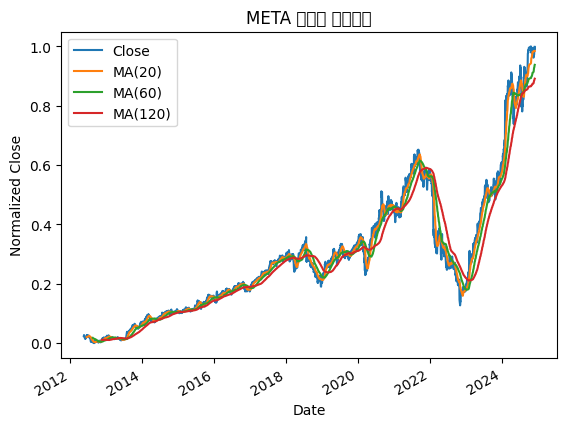

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

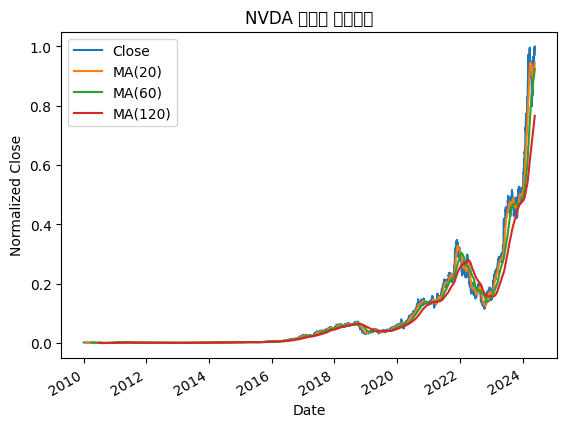

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

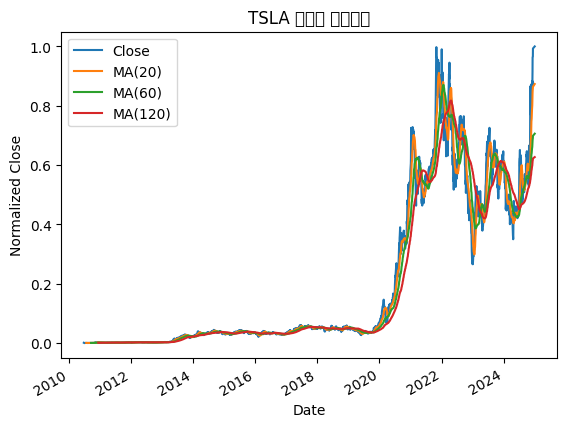

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

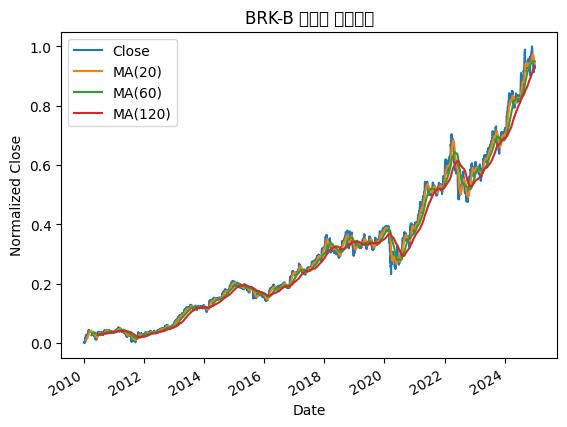

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

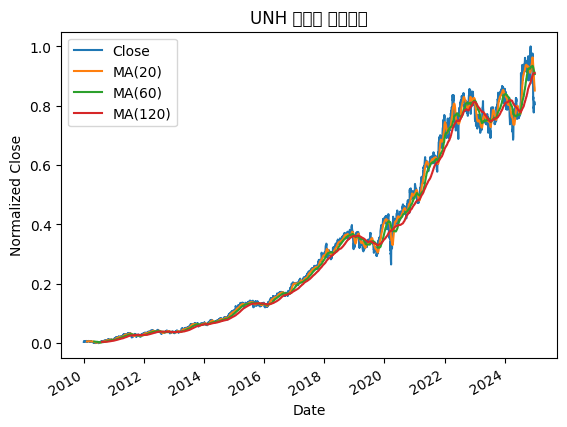

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50752 (\N{HANGUL SYLLABLE WA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46041 (\N{HANGUL SYLLABLE DONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

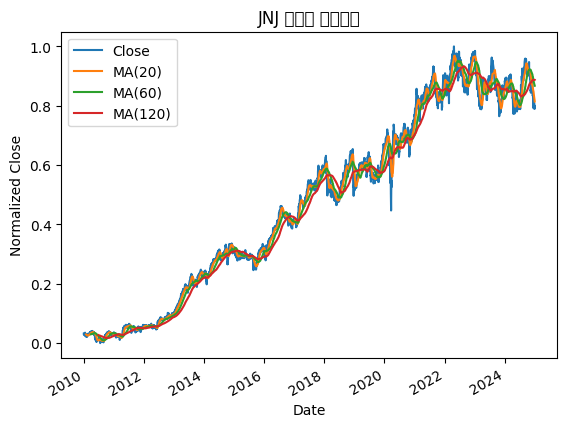

<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 47785 (\N{HANGUL SYLLABLE MOG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 44032 (\N{HANGUL SYLLABLE GA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-9-e05996dbae92>:68: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/loca

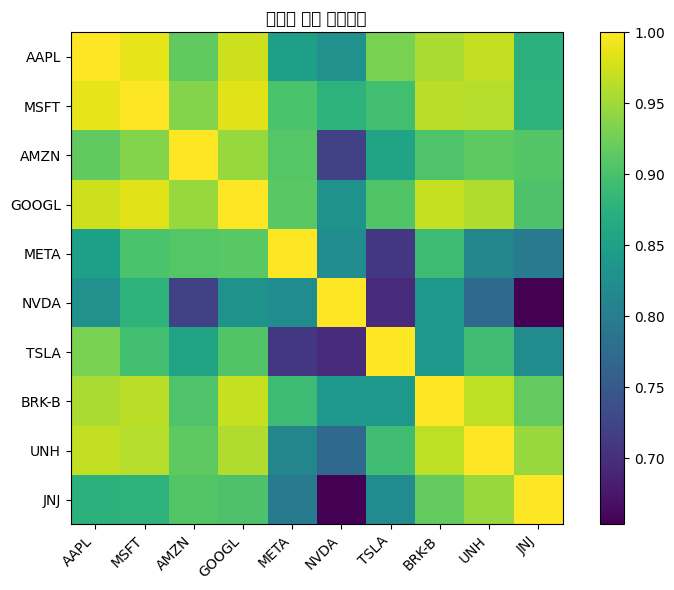

In [ ]:

import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 경로 설정
DATA_DIR = '/content/drive/MyDrive/시계열/data/preprocessed'

# 1) 데이터 불러오기
def load_all_data(data_dir=DATA_DIR):
    """폴더 내 *_processed.csv 파일을 모두 읽어와서
       딕셔너리 {ticker: DataFrame} 형태로 반환."""
    files = glob.glob(os.path.join(data_dir, '*_processed.csv'))
    data = {}
    for fp in files:
        ticker = os.path.basename(fp).replace('_processed.csv','')
        df = pd.read_csv(fp, parse_dates=['Date'], index_col='Date')
        data[ticker] = df
    return data

data_dict = load_all_data()

# 2) 수익률(로그 리턴) 계산 및 분포 히스토그램
plt.figure()
for ticker, df in data_dict.items():
    # 로그 수익률 계산: 0 또는 음수인 값은 제거
    close = df['Close']
    valid = (close > 0) & (close.shift(1) > 0)
    log_return = np.log(close / close.shift(1))
    log_return = log_return[valid]  # 유효한 값만 사용
    log_return = log_return.replace([np.inf, -np.inf], np.nan).dropna()

    # 시각화
    log_return.hist(bins=50, alpha=0.5, label=ticker)

plt.title('종목별 일간 로그 수익률 분포')
plt.xlabel('Log Return')
plt.ylabel('Frequency')
plt.legend()
plt.show()


# 3) 이동평균 시계열 플롯 (20, 60, 120일)
for ticker, df in data_dict.items():
    plt.figure()
    df['Close'].plot(label='Close')
    df['Close'].rolling(window=20).mean().plot(label='MA(20)')
    df['Close'].rolling(window=60).mean().plot(label='MA(60)')
    df['Close'].rolling(window=120).mean().plot(label='MA(120)')
    plt.title(f'{ticker} 종가와 이동평균')
    plt.xlabel('Date')
    plt.ylabel('Normalized Close')
    plt.legend()
    plt.show()

# 4) 종목별 종가 상관관계 히트맵
# 하나의 DataFrame으로 합치기
close_df = pd.DataFrame({t: df['Close'] for t, df in data_dict.items()})
corr = close_df.corr()

plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45, ha='right')
plt.yticks(range(len(corr)), corr.index)
plt.title('종목별 종가 상관관계')
plt.tight_layout()
plt.show()


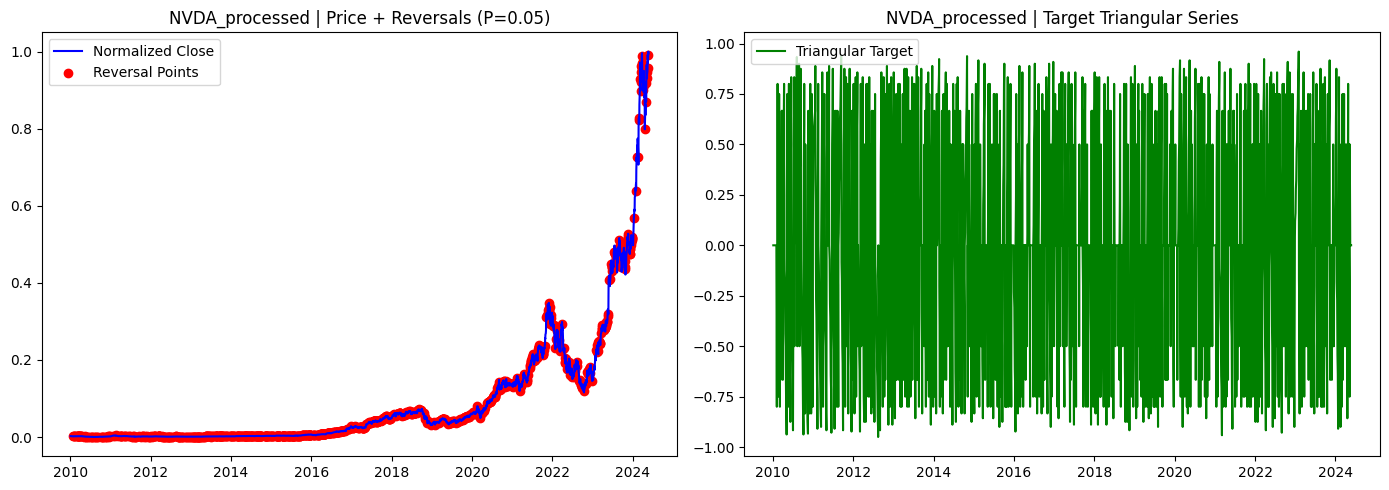

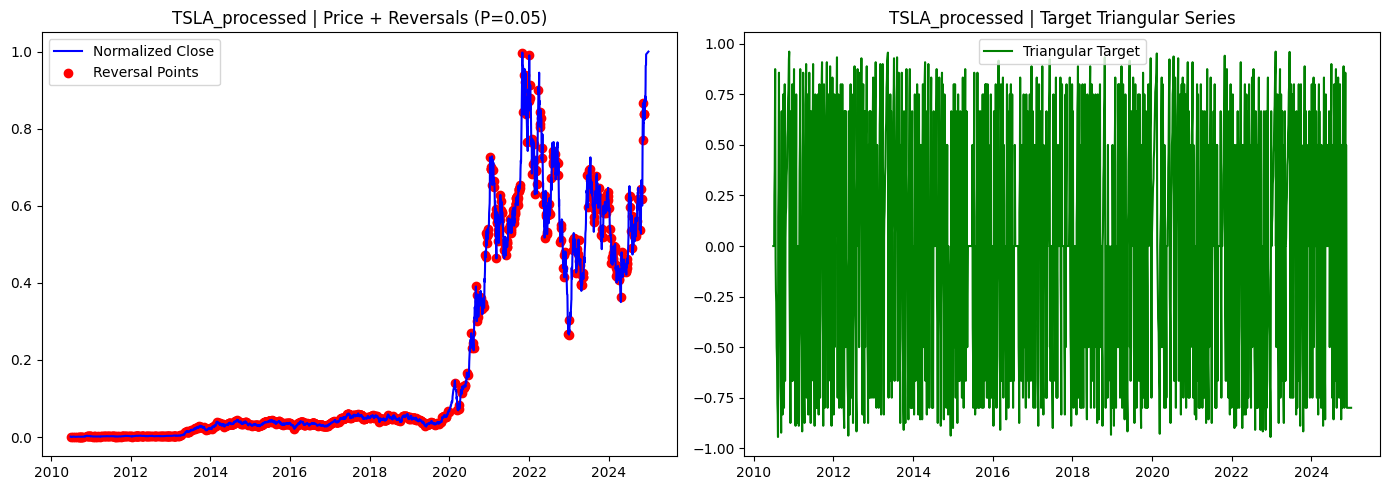

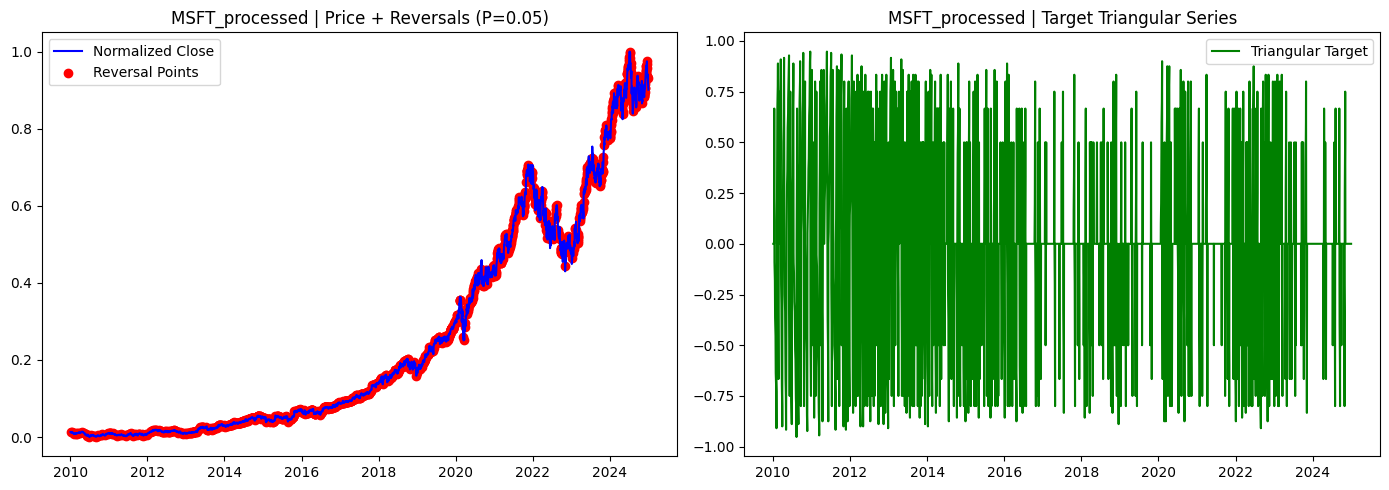

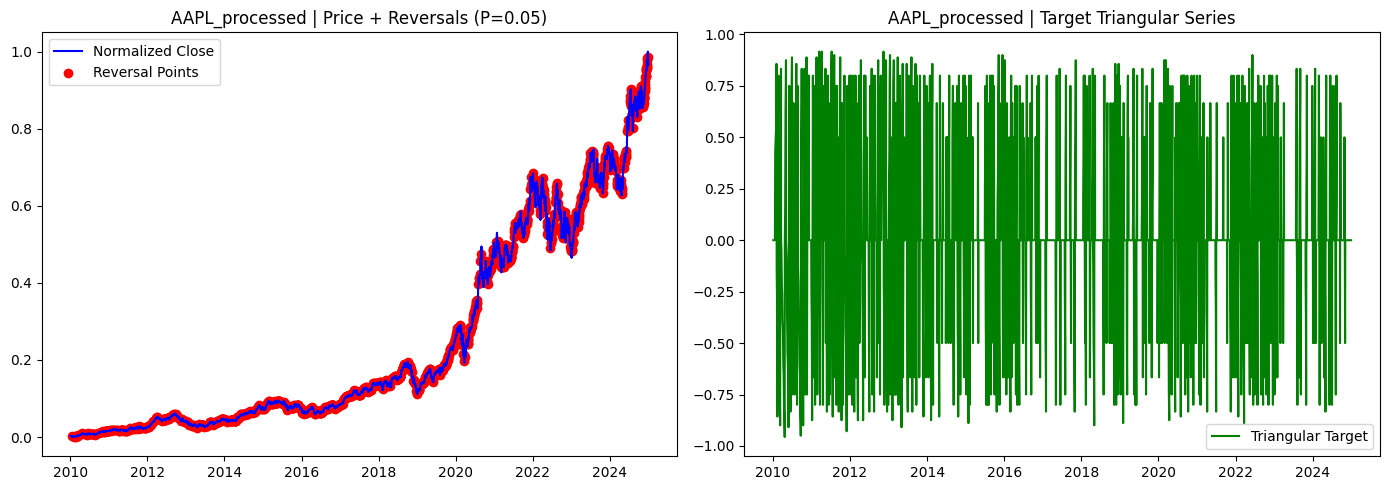

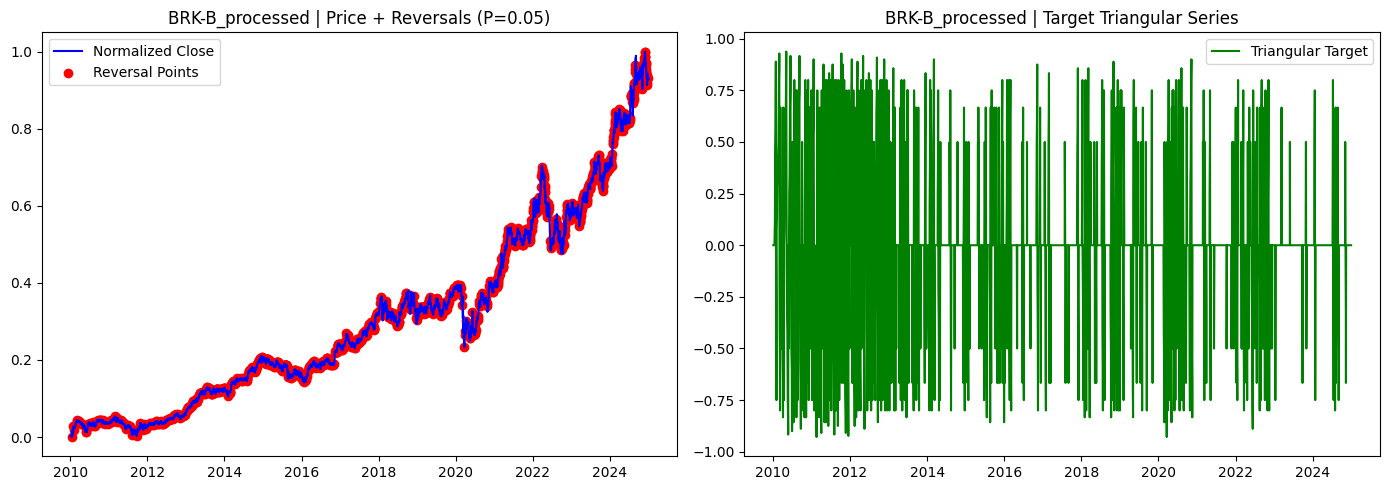

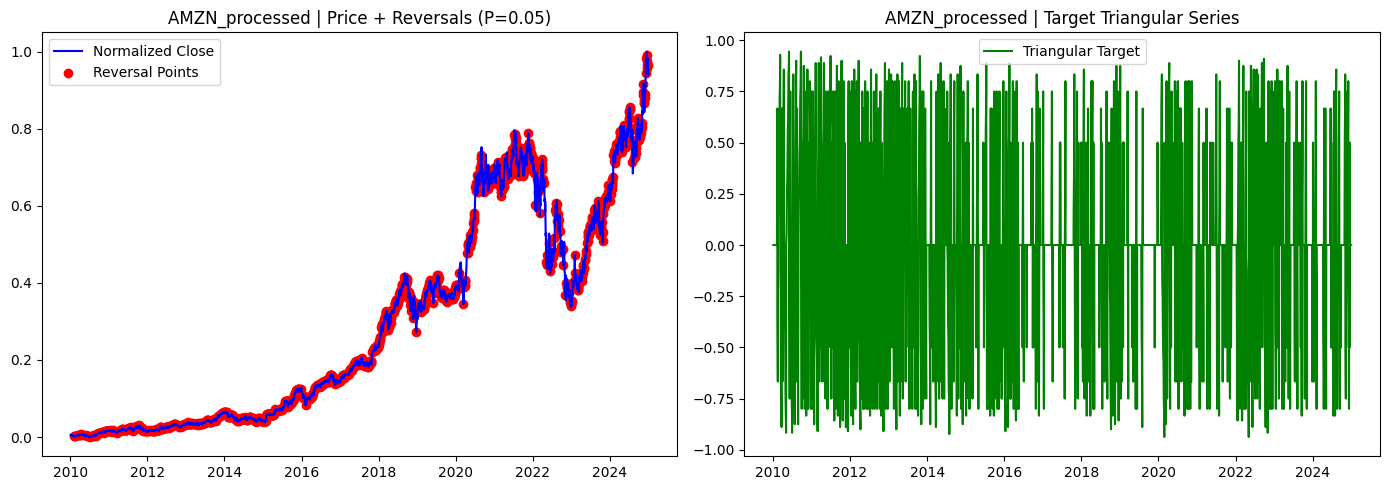

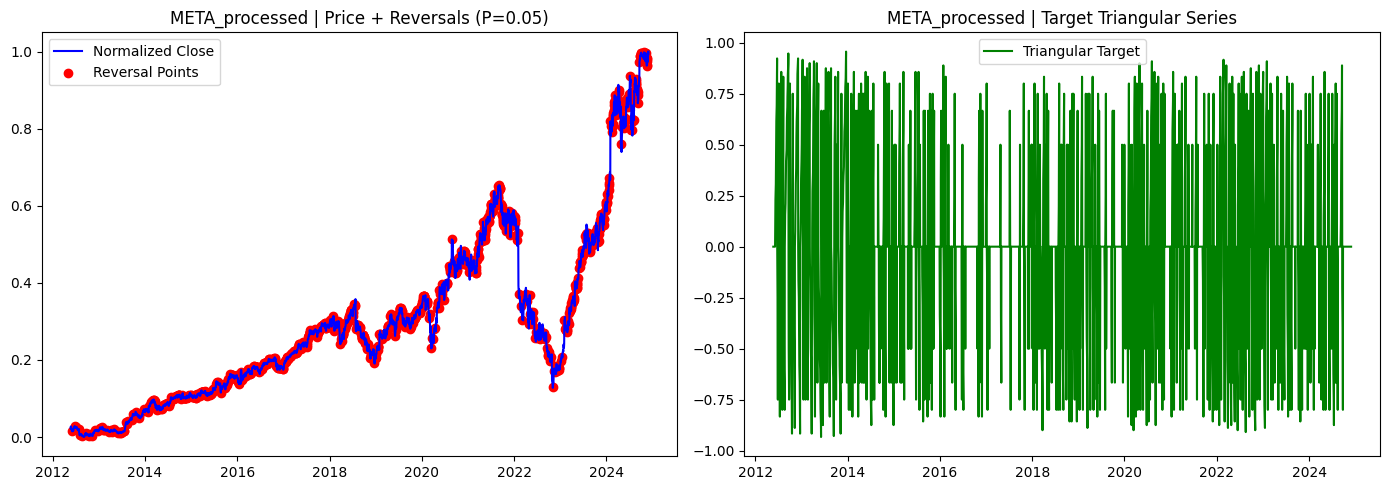

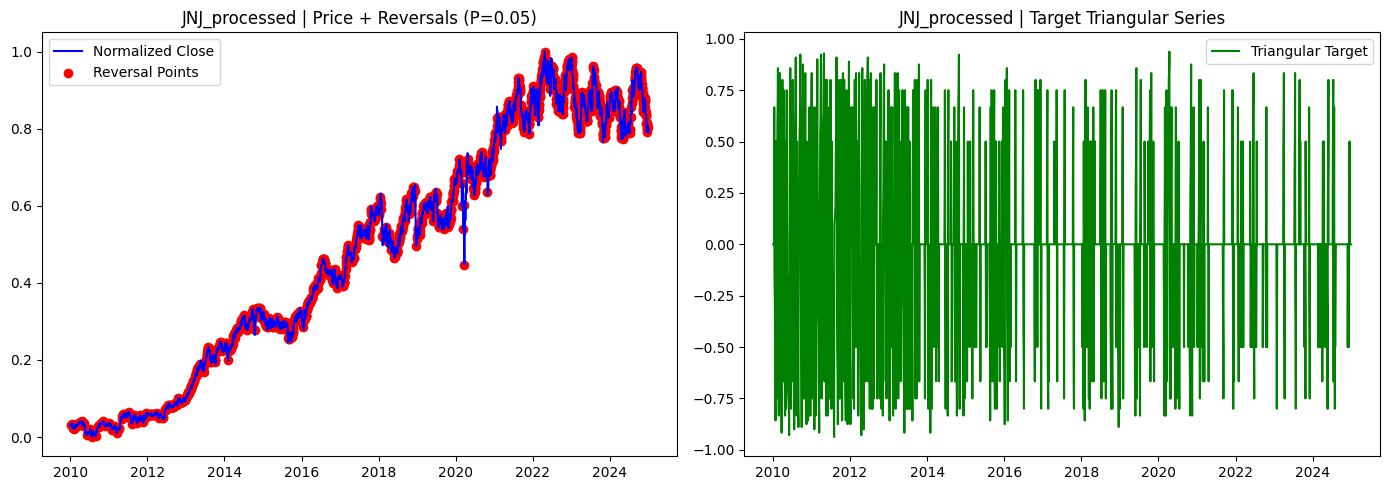

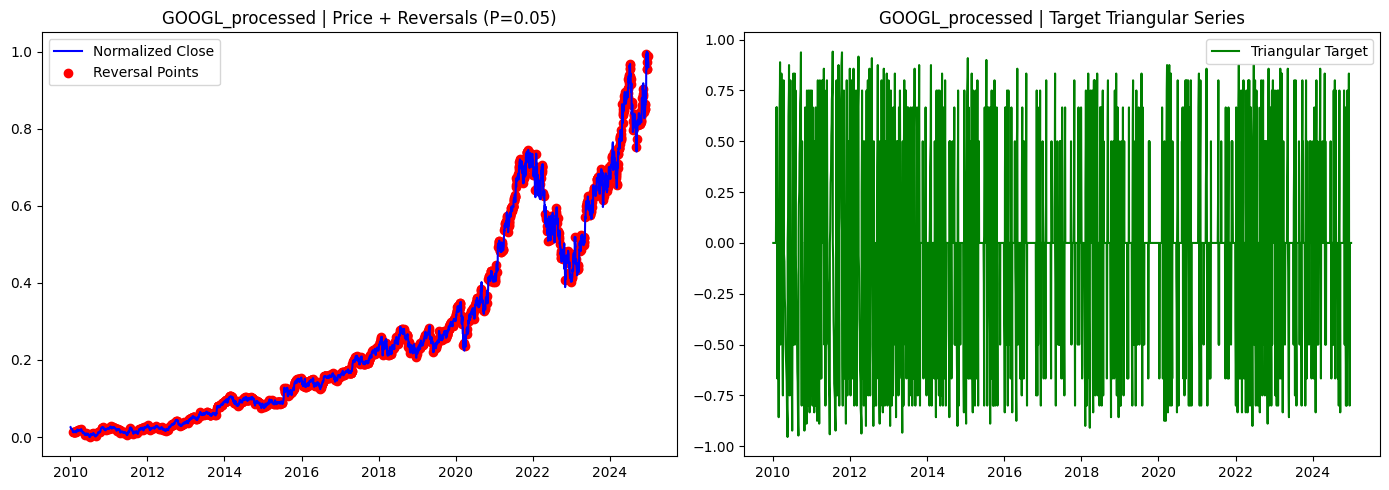

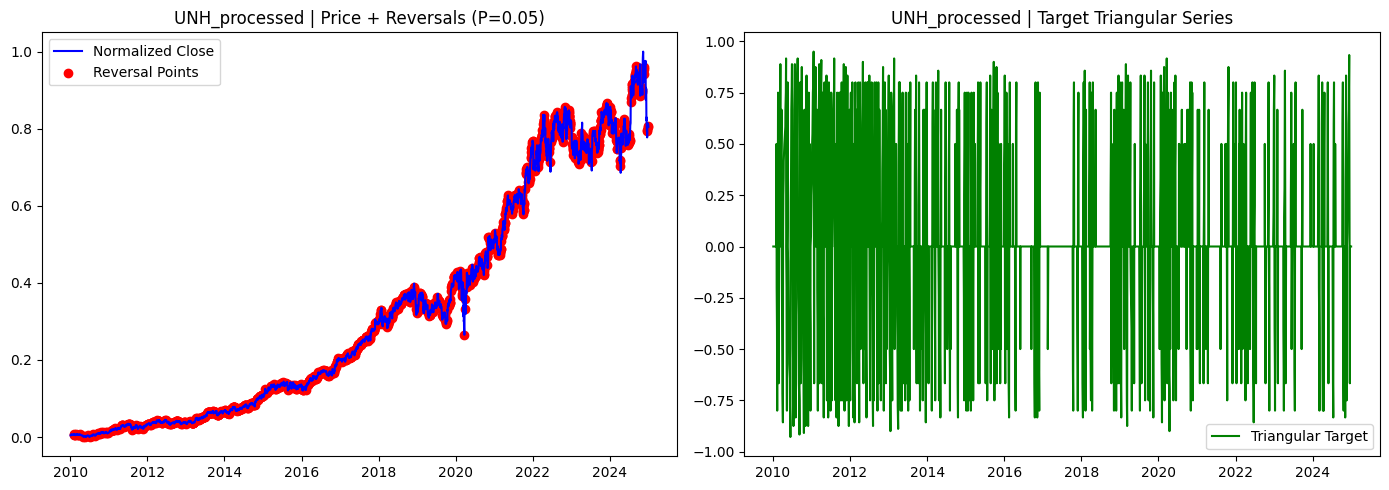

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 리버설 포인트 찾기 (보완)
def find_reversal_points(prices, P=0.05, T=5):
    n = len(prices)
    extrema_idx = []
    direction = None  # 초기 방향 없음

    for i in range(T, n - T):
        window = prices[i - T:i + T + 1]
        center = prices[i]
        max_p = np.max(window)
        min_p = np.min(window)

        if direction in [None, -1] and center >= max_p * (1 - P):
            extrema_idx.append(i)
            direction = 1
        elif direction in [None, 1] and center <= min_p * (1 + P):
            extrema_idx.append(i)
            direction = -1

    return extrema_idx

# 삼각파 타겟 생성
def get_triangular_target(length, extrema_idx):
    target = np.zeros(length)
    for i in range(1, len(extrema_idx)):
        start, end = extrema_idx[i - 1], extrema_idx[i]
        if end <= start:  # 방어적 코딩
            continue
        sign = 1 if i % 2 == 1 else -1
        slope = sign * 1.0 / (end - start)
        for j in range(start, end):
            target[j] = slope * (j - start)

    # 마지막 구간 보완 (마지막 extrema 이후 flat 유지)
    if len(extrema_idx) > 1 and extrema_idx[-1] < length:
        target[extrema_idx[-1]:] = target[extrema_idx[-1]-1]
    return target

# 최적의 P 탐색
def find_optimal_P(prices, T=5, min_points=15, max_points=60, step=0.01):
    best_P = None
    for P in np.arange(0.01, 0.11, step):
        extrema_idx = find_reversal_points(prices, P, T)
        count = len(extrema_idx)
        if min_points <= count <= max_points:
            best_P = P
    return best_P if best_P is not None else 0.05

# 전체 타겟 생성
def generate_all_targets(processed_dir, target_dir, T=5, min_points=15, max_points=60, visualize=True):
    os.makedirs(target_dir, exist_ok=True)

    for file in os.listdir(processed_dir):
        if not file.endswith('.csv'):
            continue

        ticker = file.replace('.csv', '')
        df = pd.read_csv(os.path.join(processed_dir, file), parse_dates=['Date'])
        df.sort_values('Date', inplace=True)
        df.reset_index(drop=True, inplace=True)

        prices = df['Close'].values
        best_P = find_optimal_P(prices, T=T, min_points=min_points, max_points=max_points)
        extrema_idx = find_reversal_points(prices, best_P, T)
        target = get_triangular_target(len(prices), extrema_idx)

        df['triangular_target'] = target
        df['reversal_P'] = best_P  # 최적 P 저장

        df.to_csv(os.path.join(target_dir, f'{ticker}.csv'), index=False)

        if visualize:
            plt.figure(figsize=(14, 5))
            plt.subplot(1, 2, 1)
            norm_price = (df['Close'] - df['Close'].min()) / (df['Close'].max() - df['Close'].min())
            plt.plot(df['Date'], norm_price, 'b', label='Normalized Close')
            plt.scatter(df['Date'].iloc[extrema_idx], norm_price[extrema_idx], c='r', label='Reversal Points')
            plt.title(f'{ticker} | Price + Reversals (P={best_P:.2f})')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(df['Date'], target, 'g', label='Triangular Target')
            plt.title(f'{ticker} | Target Triangular Series')
            plt.legend()
            plt.tight_layout()
            plt.show()


# 경로 설정 및 실행
processed_dir = '/content/drive/MyDrive/시계열/data/preprocessed'
target_dir = '/content/drive/MyDrive/시계열/data/target1'

generate_all_targets(processed_dir, target_dir, visualize=True)
